# **Bird Species Classification(BirdCLEF 2024)**

Monitoring and assessing avian biodiversity over large areas is critical for evaluating ecological ‎restoration projects. Traditional observer-based surveys are costly and logistically challenging, ‎especially in regions like the Western Ghats of India. This biodiversity hotspot faces significant ‎threats from landscape alterations and climate changes, endangering its unique ecosystems and ‎bird species. Birds, being excellent indicators of biodiversity changes, necessitate effective ‎monitoring methods to gauge the success of conservation efforts.‎
Traditional surveys struggle with:‎

**High Costs:** Extensive surveys require significant financial and human resources.‎

**Logistical Challenges:** Accessing remote or vast areas regularly is difficult.‎

**Temporal and Spatial Coverage:** Limited ability to provide continuous monitoring over large ‎regions.‎


By combining **Passive Acoustic Monitoring (PAM) with sophisticated machine learning ‎techniques****, this solution offers an efficient and scalable method for monitoring bird species in ‎the Western Ghats, addressing the limitations of traditional surveys and bolstering conservation ‎efforts to protect and restore avian biodiversity in this critical region. PAM utilizes automated ‎recording devices that are cost-effective to deploy and maintain, significantly reducing expenses ‎compared to human observers. The integration of machine learning enables the analysis of vast ‎amounts of audio data, facilitating extensive area monitoring without requiring constant human ‎presence. Additionally, PAM provides continuous, real-time monitoring, delivering a more ‎comprehensive understanding of avian biodiversity and its fluctuations. This approach holds ‎significant potential for broader application in global biodiversity conservation initiatives.‎

# **Import Libraries**

In [3]:
import os
import glob
!pip install noisereduce 
import noisereduce as nr
import shutil
import zipfile
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import numpy as np
!pip install plotly
import plotly.express as px
import librosa
from IPython.display import Audio
import pandas as pd
import pickle
from joblib import dump, load
from pathlib import Path
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [4]:
BASE_PATH = '/kaggle/input/birdclef-2024'

# **Data Collection**

In [5]:
meta_data = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
meta_data.head(4)

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   

      scientific_name             common_name            author  \
0  Muscicapa dauurica  Asian Brown Flycatcher    Matt Slaymaker   
1  Muscicapa dauurica  Asian Brown Flycatcher  Magnus Hellström   
2  Muscicapa dauurica  Asian Brown Flycatcher     Stuart Fisher   
3  Muscicapa dauurica  Asian Brown Flycatcher         vir joshi   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   
2  Creative Commons Attribution-NonCommercial-Sha...     2.5   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                 url             filename  
0  https://www.xeno-canto.org/134896  asbfly/XC134896.ogg  
1  https://www.xeno-canto.org/164848  asbfly/XC164848.ogg  
2  https://www.xeno-canto.org/175797  asbfly/XC175797.ogg  
3  https://www.xeno-canto.org/207738  asbfly/XC207738.ogg

In [6]:
meta_data['filepath'] = BASE_PATH + '/train_audio/' + meta_data.filename

# **Exploratory Data Analysis (EDA)**

In [7]:
# Check for missing values
print(meta_data.isnull().sum())

primary_label         0
secondary_labels      0
type                  0
latitude            378
longitude           378
scientific_name       0
common_name           0
author                0
license               0
rating                0
url                   0
filename              0
filepath              0
dtype: int64


In [8]:
# Basic statistics
print(meta_data.describe())

           latitude     longitude        rating
count  24081.000000  24081.000000  24459.000000
mean      32.537040     43.640699      3.843493
std       19.440382     50.191352      1.100840
min      -43.524000   -171.765400      0.000000
25%       17.160100      2.545700      3.000000
50%       37.155100     26.687600      4.000000
75%       49.114400     85.319300      5.000000
max       71.964000    177.447800      5.000000


In [9]:
# Number of birds in each species
meta_data.primary_label.value_counts()

primary_label
zitcis1    500
lirplo     500
litgre1    500
comgre     500
comkin1    500
          ... 
blaeag1      6
wynlau1      6
niwpig1      5
asiope1      5
integr       5
Name: count, Length: 182, dtype: int64

In [10]:
# visualize the relationship between primary and secondary bird labels 
tmp = meta_data[meta_data['secondary_labels'] != '[]'].iloc[:40]
fig = px.sunburst(tmp, path=['primary_label', 'secondary_labels'] )
fig.update_layout(
         title="Primary & Secondary Labels ",
    )
fig.show()

In [11]:
# Create a copy of the df_train DataFrame
tmp = meta_data.copy()

# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    tmp,  # Use the tmp DataFrame as the data source
    lat="latitude",  # Latitude column for plotting points
    lon="longitude",  # Longitude column for plotting points
    color="primary_label",  # Color points based on the primary_label column
    zoom=0.1,  # Initial zoom level of the map
    title='Bird Recordings Loaction'  # Title of the plot
)

# Update the layout of the plot to use the "open-street-map" style for the map background
fig.update_layout(mapbox_style="open-street-map")

# Update the layout of the plot to set the margin around the map
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})

# Display the scatter mapbox plot
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [12]:
fig = px.scatter_mapbox(meta_data, lat='latitude', lon='longitude', color='common_name', 
                        hover_name='common_name', hover_data=['latitude', 'longitude'], 
                        title='Origin of Bird Species',
                        zoom=1, height=600, template='plotly_dark')
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



It visualizes the geographical distribution of bird species represented in the 'meta_data' DataFrame. Each point on the map represents a bird species, colored by its common name. Hovering over a point displays additional information such as latitude and longitude. 

In [13]:
# Species diversity by region
region_species_count = meta_data.groupby(['latitude', 'longitude'])['primary_label'].nunique().reset_index()
region_species_count.columns = ['latitude', 'longitude', 'species_count']
fig = px.scatter_mapbox(region_species_count, lat='latitude', lon='longitude', size='species_count',
                        color='species_count', color_continuous_scale='Viridis', zoom=1, height=600,
                        title='Species Diversity by Region')
fig.update_layout(mapbox_style="carto-positron")
fig.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



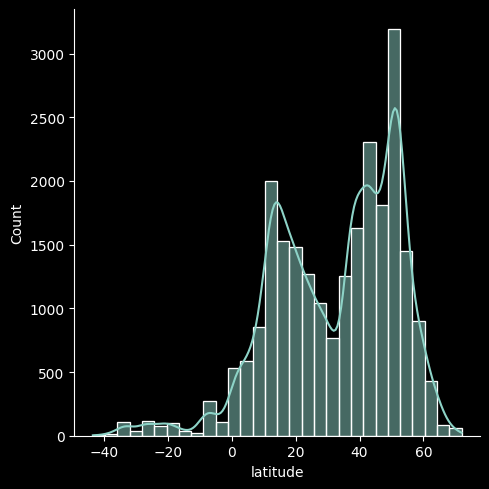

In [14]:
sns.displot(data=meta_data,x='latitude',bins=30,kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



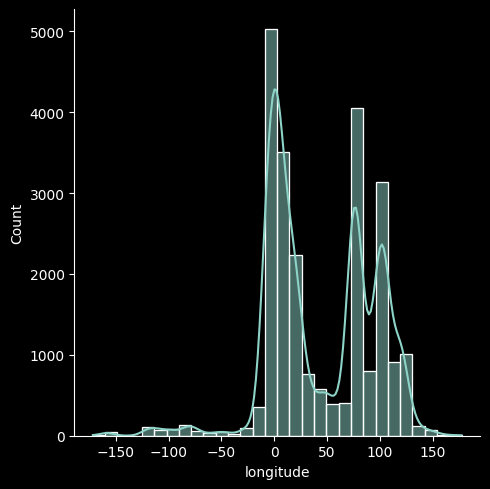

In [15]:
sns.displot(data=meta_data,x='longitude',bins=30,kde=True)

For latitude and longitude in the train_metadata dataset, it might be more appropriate to fill missing values with the median to avoid potential distortions from outliers.

In [16]:
median_latitude = meta_data['latitude'].median()
median_longitude = meta_data['longitude'].median()
#Fill missing latitude and longitude with the mean values
meta_data['latitude'] = meta_data['latitude'].fillna(median_latitude)
meta_data['longitude'] = meta_data['longitude'].fillna(median_longitude)

In [17]:
# Check if there are any remaining missing values
print(meta_data.isnull().sum())

primary_label       0
secondary_labels    0
type                0
latitude            0
longitude           0
scientific_name     0
common_name         0
author              0
license             0
rating              0
url                 0
filename            0
filepath            0
dtype: int64


In [18]:
def audio_waveframe(file_path):
    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path)
    # Calculate the duration of the audio file
    duration = len(audio_data) / sampling_rate
    # Create a time array for plotting
    time = np.arange(0, duration, 1/sampling_rate)
    # Plot the waveform
    plt.figure(figsize=(30, 4))
    plt.plot(time, audio_data, color='blue')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plot = plt.show()
    return plot

**waveform** visualizes the amplitude (volume) of an audio signal over time. This allows you to see how the sound changes, including the presence of different frequencies, the amplitude of the signal, and any patterns or noise within the audio.

In [20]:
def spectrogram(file_path):
    # Compute the short-time Fourier transform (STFT)
    n_fft = 500  # Number of FFT points 2048
    hop_length = 50  # Hop length for STFT 512
    audio_data, sampling_rate = librosa.load(file_path)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    # Convert the magnitude spectrogram to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    # Plot the spectrogram
    plt.figure(figsize=(30, 6))
    librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plot = plt.show()
    return plot



**A spectrogram** is a visual representation of the spectrum of frequencies in a signal as it varies with time. It is commonly used in the fields of audio processing, signal processing, and speech analysis to analyze the frequency content of signals, especially non-stationary signals.

In [21]:
def audio_analysis(file_path):
    aw = audio_waveframe(file_path)
    spg = spectrogram(file_path)
    return aw, spg

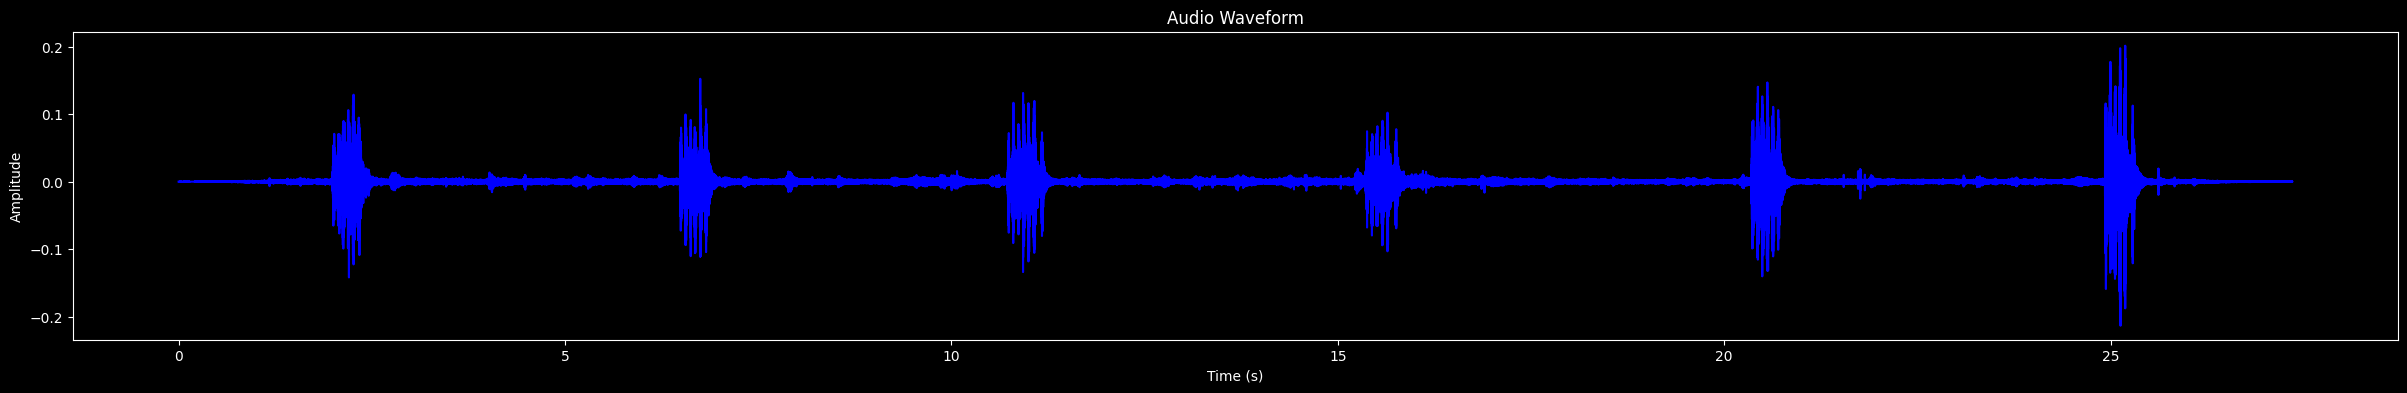

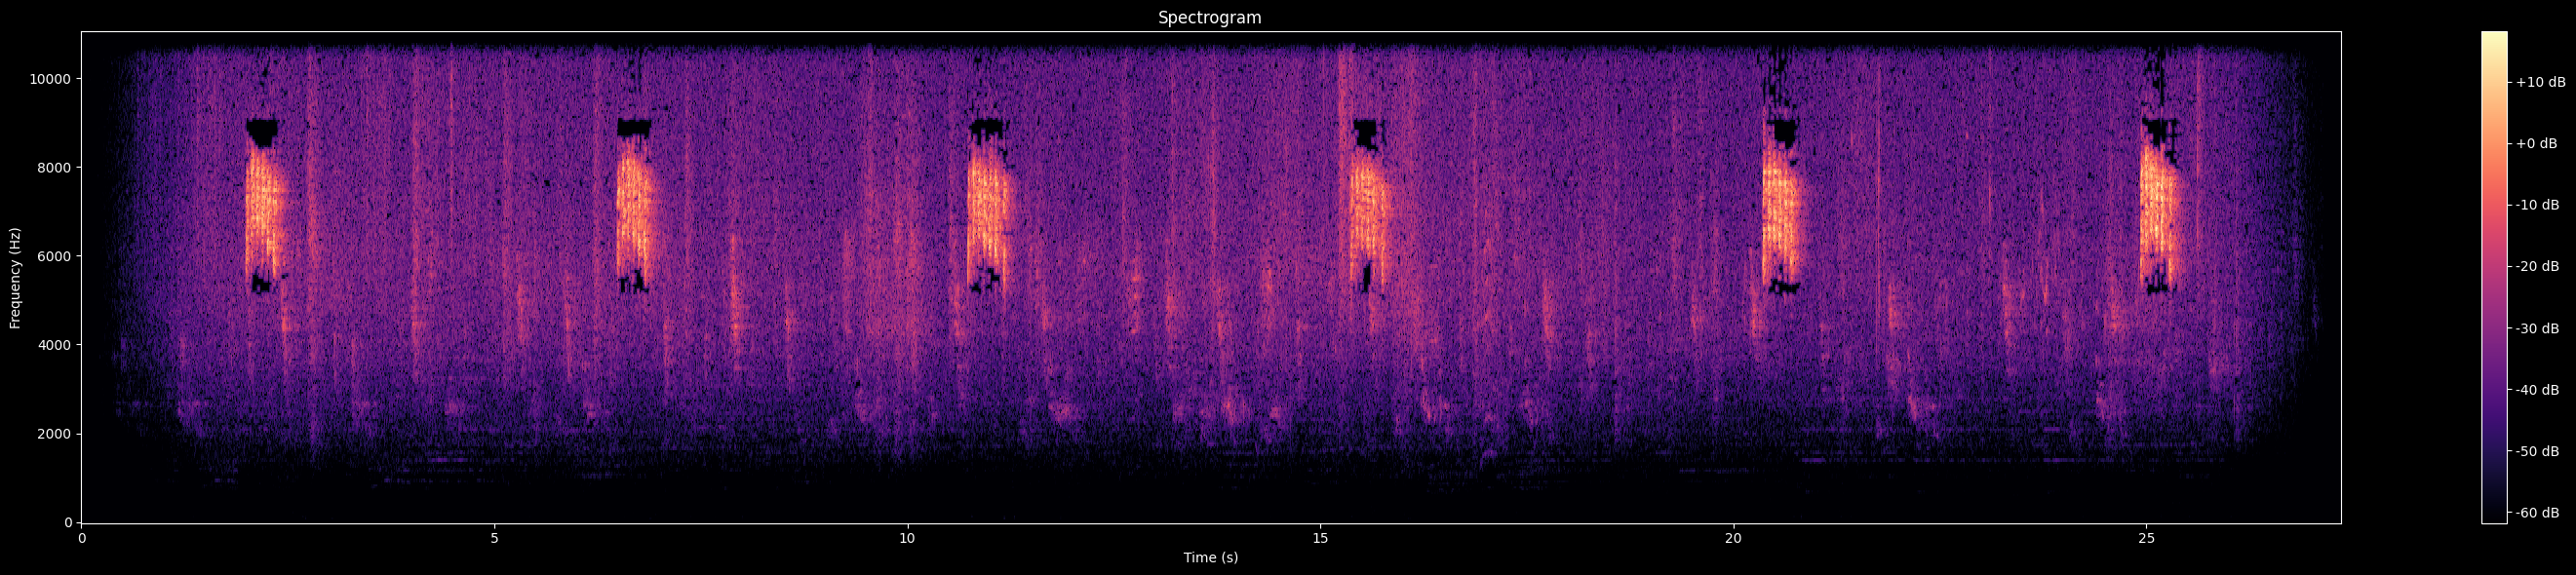

In [22]:
audio_analysis('/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg')
Audio('/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg')

# **Feature Engineering**

# 1. Feature Extraction

In [23]:
def normalize_and_denoise(audio,sample_rate):
#     # Normalize audio data
    audio = audio / np.max(np.abs(audio))
    
    # Apply Spectral Subtraction Filter
    filtered_audio = nr.reduce_noise(y=audio, sr=sample_rate)
    
    # Apply Wiener Filter for noise reduction
    #filtered_audio = wiener(audio)
    
    return filtered_audio

**NoiseReduce** is a Python library designed for noise reduction in audio signals. It provides simple and effective ‎methods to reduce background noise from audio recordings, enhancing the clarity of the audio ‎signal, which is especially useful in tasks such as speech recognition, audio processing, and, as in ‎your case, bird song identification.‎
The library typically applies spectral subtraction techniques to reduce noise. This involves ‎estimating the noise spectrum from the audio signal and subtracting it from the original signal ‎to produce a cleaner version.‎


In [24]:
# Function to extract features from audio file
def extract_features(file_path):
    # Load audio ile
      
      # Normalize and denoise audio
    audio,sample_rate=librosa.load(file_path) 
    # audio,sample_rate = resample_audio(file_path)
    audio = normalize_and_denoise(audio, sample_rate)
#     audio = removeSilence(audio)
    
    # Extract features using Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Flatten the features into a 1D array
    flattened_features = np.mean(mfccs.T, axis=0)
    return flattened_features

**Mel-Frequency Cepstral Coefficients (MFCCs)**  are a widely used feature extraction technique ‎in audio signal processing. They provide a compact representation of the spectral properties of ‎an audio signal, making them suitable for tasks such as speech and bird call recognition.

In [ ]:
from tqdm import tqdm
extracted_features = []
for i in tqdm(meta_data['filepath']):
    features = extract_features(file_path=i)
    # print(features)
    extracted_features.append(features)

In [ ]:
with open("extracted_features", "wb") as file:   #Pickling
	pickle.dump(extracted_features, file)

In [25]:
with open("/kaggle/input/extracted-features/extracted_featuress", "rb") as file:   # Unpickling
	pickled_extracted_features = pickle.load(file)

# 2. Label Encoding

In [26]:
# Path to the directory containing your audio dataset
dataset_dir = '/kaggle/input/birdclef-2024/train_audio'
# Initialize an empty dictionary to store the mapping between audio files and labels
label_mapping = {}
# Iterate over subdirectories (classes) in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    # Check if the item in the dataset directory is a directory
    if os.path.isdir(label_dir):
        # Iterate over audio files in the subdirectory (class)
        for audio_file in os.listdir(label_dir):
            # Add the mapping between audio file path and label to the dictionary
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label

In [27]:
# Create a list of tuples containing the audio file paths and labels
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
# Create a Pandas DataFrame from the list of tuples
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])
annotated_data

audio_file_path    label
0      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1
1      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1
2      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1
3      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1
4      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1
...                                                  ...      ...
24454  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr
24455  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr
24456  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr
24457  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr
24458  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr

[24459 rows x 2 columns]

In [28]:
label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])
annotated_data

audio_file_path    label  \
0      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1   
1      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1   
2      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1   
3      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1   
4      /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1   
...                                                  ...      ...   
24454  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr   
24455  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr   
24456  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr   
24457  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr   
24458  /kaggle/input/birdclef-2024/train_audio/litegr...   litegr   

       encoded_label  
0                137  
1                137  
2                137  
3                137  
4                137  
...              ...  
24454            106  
24455            106  
24456            106  
24457            106  
24458            106  

[24459 rows x 3 columns]

**Label encoding** is an essential step when you need to convert categorical labels into a numerical ‎format that can be used by machine learning models. You can incorporate label encoding after ‎loading the dataset and extracting features but before feeding the data into your model.‎

# 3. Random Sampling Data

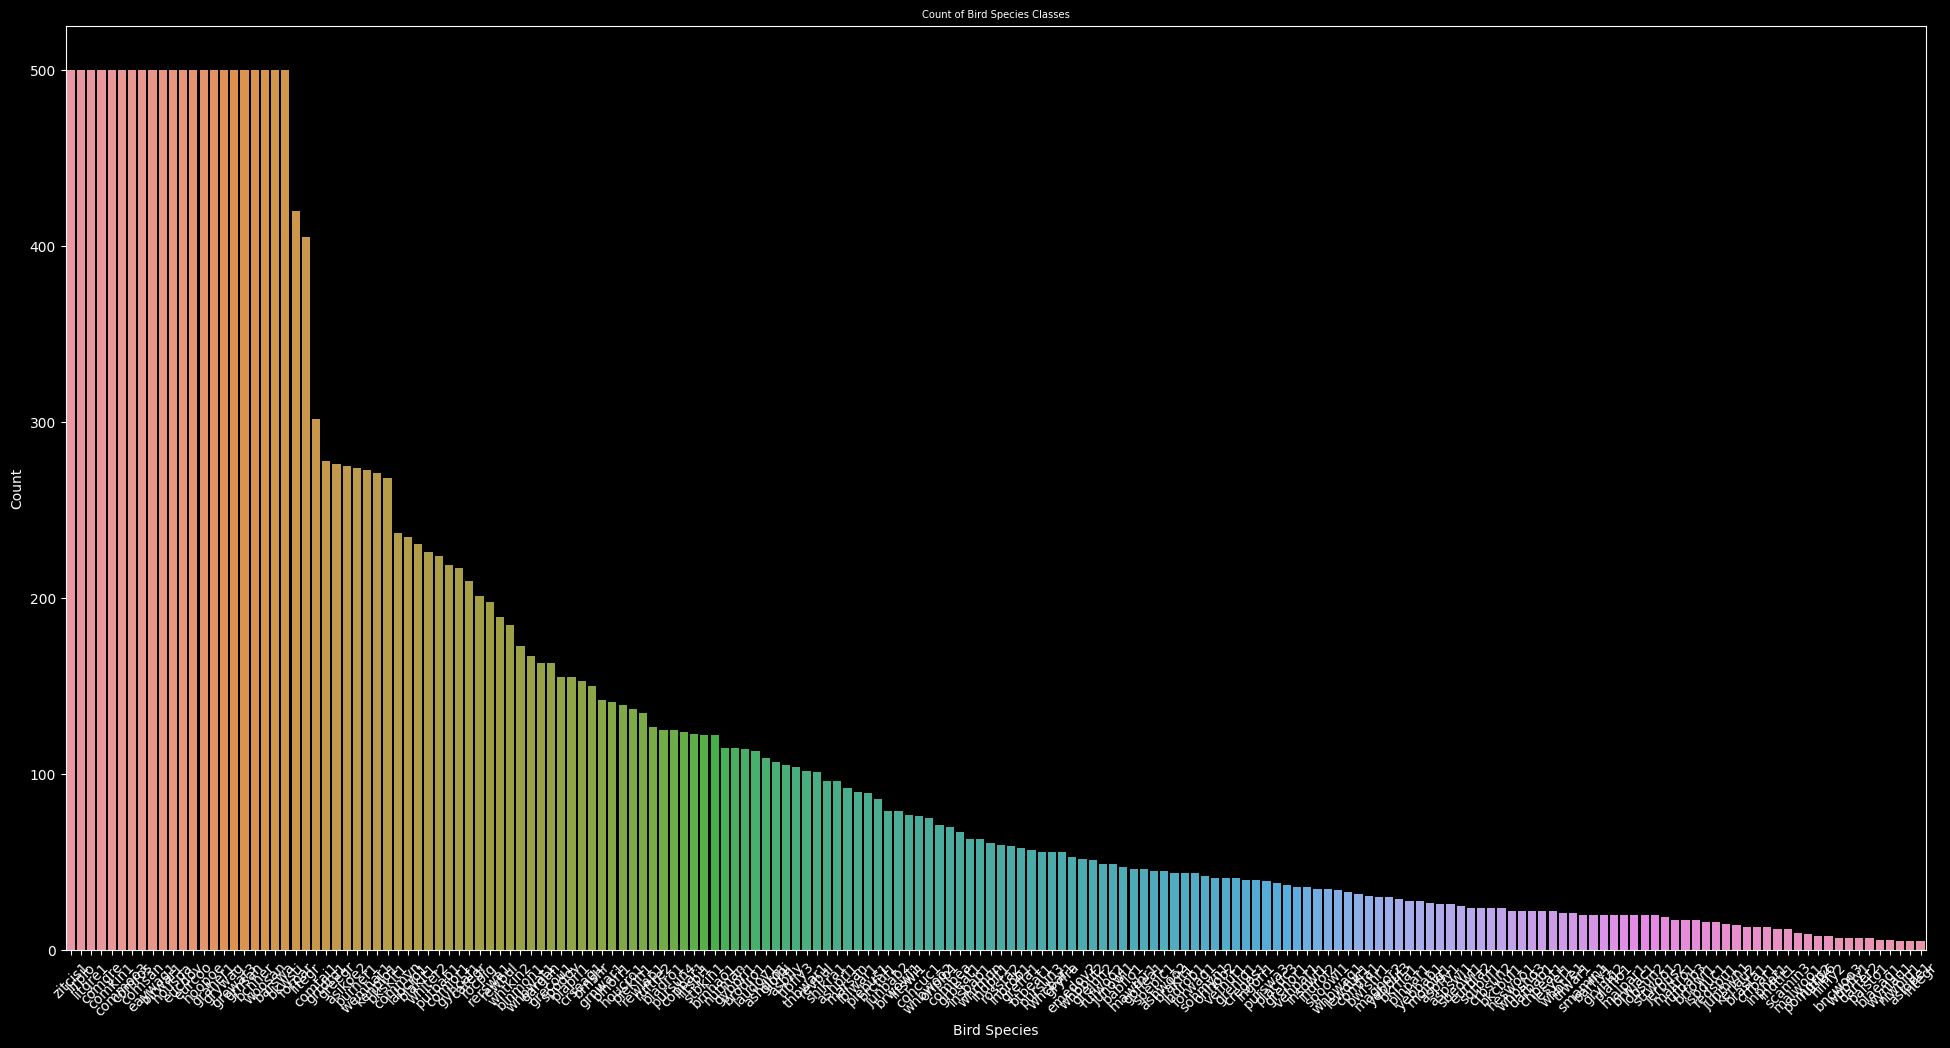

In [11]:
plt.figure(figsize=(24, 12))
sns.countplot(x='primary_label', data=meta_data, order=meta_data['primary_label'].value_counts().index)
plt.xticks(rotation=45)
plt.rc('font', size=6)
plt.title('Count of Bird Species Classes')
plt.xlabel('Bird Species')
plt.ylabel('Count')
plt.show()

**Imbalanced data** refers to a situation in classification problems where the distribution of class ‎labels in the dataset is skewed or disproportionate. In other words, one or more classes have ‎significantly fewer samples compared to other classes‎

In [29]:
x = np.vstack(pickled_extracted_features)
y = annotated_data['encoded_label']

print(x.shape)
print(y.shape)

(24459, 40)
(24459,)


In [30]:
ros = RandomOverSampler(random_state=42)
features_resampled, labels_reshampled = ros.fit_resample(x, y)

print(features_resampled.shape)
print(labels_reshampled.shape)

(91000, 40)
(91000,)


**The RandomOverSampler** is a technique used in imbalanced classification problems to balance ‎the class distribution by randomly duplicating samples from the minority class(es) until they are ‎represented in a proportion similar to the majority class. This technique helps address the issue ‎of imbalanced datasets, where one or more classes are significantly underrepresented ‎compared to others.‎

# **Model Training**

In [31]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features_resampled, labels_reshampled, test_size=0.2, random_state=42)

In [32]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model = xgb_model.fit(x_train, y_train)
y_predict = model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.8837912087912088


In [21]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model = random_forest_classifier.fit(x_train, y_train)
y_predict = random_forest_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.887087912087912


In [ ]:
from sklearn.svm import SVC
# Train and evaluate SVM Classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_model = svm_classifier.fit(x_train, y_train)
y_predict_svm = svm_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict_svm)
print("Accuracy:", accuracy)

# **Hyperparameter tuning**

In [ ]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4],

}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, 
                               scoring='accuracy', cv=5, verbose=1, n_jobs=1)

# Fit GridSearchCV
xgb_grid_search.fit(x_train, y_train)

# Get the best parameters and best score
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_

print("Best XGBoost Parameters:", xgb_best_params)
print("Best XGBoost CV Accuracy:", xgb_best_score)

# Train the model with the best parameters
xgb_best_model = xgb_grid_search.best_estimator_
y_predict = xgb_best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict)
print("XGBoost Test Accuracy:", accuracy)

In [34]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [35]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [20, 30],

}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with limited parallel jobs
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, 
                              scoring='accuracy', cv=5, verbose=1, n_jobs=1)  # Limited to 2 jobs

# Fit GridSearchCV
rf_grid_search.fit(x_train, y_train)

# Get the best parameters and best score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

print("Best Random Forest Parameters:", rf_best_params)
print("Best Random Forest CV Accuracy:", rf_best_score)

# Train the model with the best parameters
rf_best_model = rf_grid_search.best_estimator_
y_predict = rf_best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict)
print("Random Forest Test Accuracy:", accuracy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Random Forest Parameters: {'max_depth': 30, 'n_estimators': 100}
Best Random Forest CV Accuracy: 0.8633791208791208
Random Forest Test Accuracy: 0.8803846153846154


# **Model Evaluation**

In [16]:
def evaluate_model(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')
    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(y_test, y_predict)
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8837912087912088
Precision: 0.8725561540883301
Recall: 0.8837912087912088
F1 Score: 0.8764832453551896


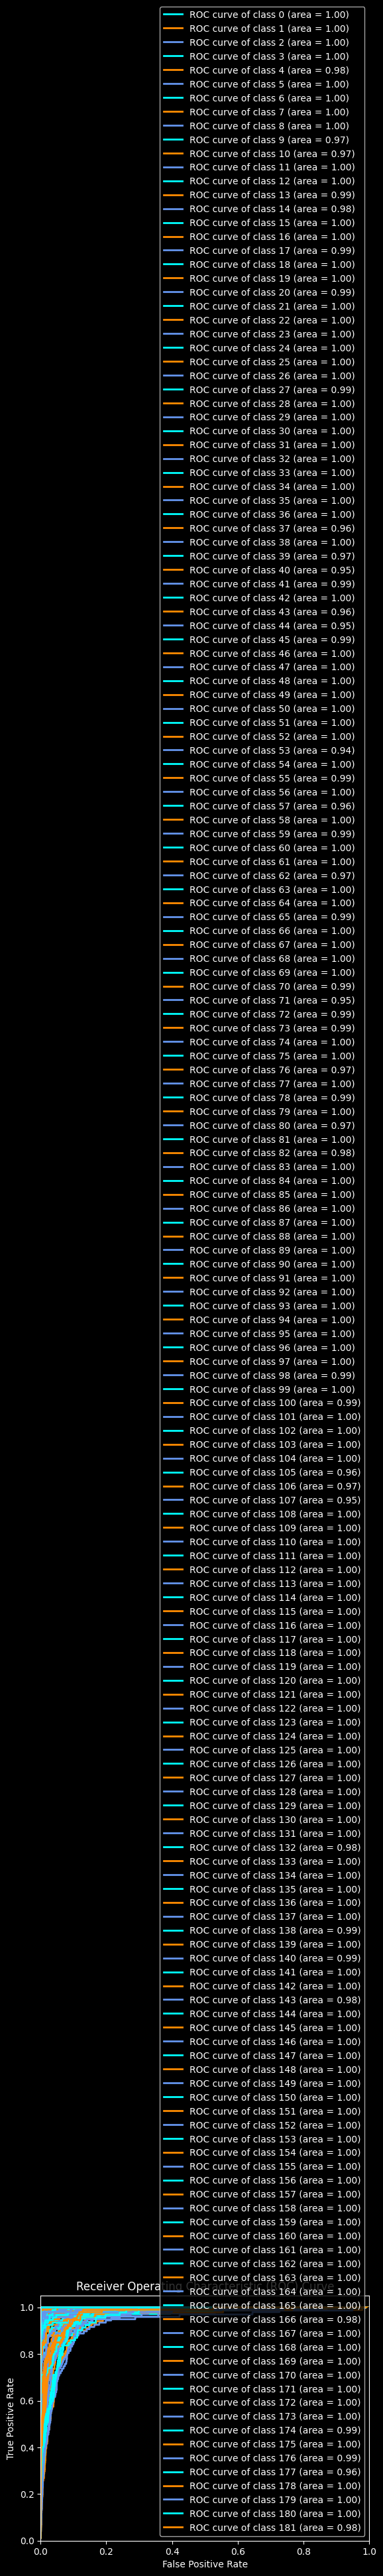

Average AUC Score: 0.9942197776214698


In [37]:
y_proba = model.predict_proba(x_test)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_bin.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC score
average_auc = np.mean(list(roc_auc.values()))
print("Average AUC Score:", average_auc)

# **Model Testing and Deployment**

In [ ]:
dump(random_forest_model, 'random_forest.joblib')

In [ ]:
model = load('/kaggle/working/random_forest.joblib')

In [ ]:
def audio_classification(file_path):
    audio = file_path
    print(audio)
    extracted_features = extract_features(audio).reshape(1, -1)
    y_predict = model.predict(extracted_features)
    labels_list = annotated_data['label'].unique()
    encoded_label = annotated_data['encoded_label'].unique()

    labels = {}
    for label, prediction in zip(encoded_label, labels_list):
        labels[label] = prediction
    if y_predict[0] in labels.keys():
        predicted = ('Predicted Class:', labels[y_predict[0]])
    return predicted

In [ ]:
file_path = '/kaggle/input/birdclef-2024/unlabeled_soundscapes/1001358022.ogg'
audio_analysis(file_path)
Audio(file_path)

In [ ]:
audio_classification(file_path)

# **Project Submission**

In [ ]:
test_soundscapes = '/kaggle/input/birdclef-2024/test_soundscapes'

for path in Path(test_soundscapes).glob("*.ogg"):
    print(path)
    print(path.stem)
    print(path.stem.split("_"))

In [ ]:
test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(test_soundscapes).glob("*.ogg")],
    columns = ["filename", "name" ,"id", "path"]
)
print(test.shape)
test.head()

In [ ]:
filenames = test.filename.values.tolist()
bird_cols = list(pd.get_dummies(meta_data['primary_label']).columns)
submission_df = pd.DataFrame(columns=['row_id']+bird_cols)
submission_df

In [ ]:
for i, file in enumerate(filenames):
    predicted = model.predict[i]
    num_rows = len(predicted)
    row_ids = [f'{file}_{(i+1)*5}' for i in range(num_rows)]
    df = pd.DataFrame(columns=['row_id']+bird_cols)
    
    df['row_id'] = row_ids
    df[bird_cols] = predicted
    
    submission_df = pd.concat([submission_df,df]).reset_index(drop=True)
 

In [ ]:
submission_df.to_csv('submission.csv', index=False)